<a href="https://colab.research.google.com/github/ailsonramon/timeseries/blob/main/TS_daily_analysis_energy_2000_2021_Brazillian_Northeast_Region.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Introdução a séries temporais



Uma série temporal é definida como um conjunto de valores que se modificam em intervalos iguais de tempo. 

Exemplo
* Valor de ativos na bolsa de valores
* População de um pais
* Quantidades de passageiros 

Os modelos utilizados para descrever séries temporais são **processos estocásticos**, isto é, processos controlados por leis probabilísticas. 



Objetivos da análise de séries temporais: 

* Investigar o mecanismos gerador da série temporal, por exemplo, analisando uma série de alturas de ondas, podemos querer saber como estas ondas foram geradas. 
* Fazer previsões de valores futuros da série, sendo de curto prazo, como séries de vendas, produçõa ou estoque, ou de longo prazo, como para séries populacionais, de produtividades etc;
* Descrever apenas o comportamento da série, construção do gráfico, verificação da existência de tendência, ciclos e variações sazonais, a construição de histogramas e diagramas de dispersão.



Neste Notebook, iremos abordar os seguintes tópicos:
1.  Leitura dos arquivos e tratamento dos dados
2. Análise exploratória dos dados
3. Transformações das séries
4. Decomposição 
5. Previsão

# 1. Leitura dos Arquivos e Tratamento dos Dados


##1.1 Importação das libs

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.seasonal import seasonal_decompose
#sets the maximum number of rows and columns displayed when a frame is pretty-printed.
pd.set_option("max_columns",20)
#graphs will be included in your notebook
%matplotlib inline
#figure formate
%config InlineBackend.figure_format = "svg"

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Referências: [SVG](https://pt.wikipedia.org/wiki/SVG)

[InlineBackend.figure_format](https://ipython.readthedocs.io/en/stable/api/generated/IPython.display.html#IPython.display.set_matplotlib_formats)

##1.2 Leitura dos Arquivos

Neste exemplo iremos utilizar os dados de energia da ons.org relacionado aos dados de demanda instantanea, no período de 2000-2021, na região Nordeste do Brazil.
disponível: http://www.ons.org.br/paginas/resultados-da-operacao/historico-da-operacao

In [2]:
url = "https://raw.githubusercontent.com/ailsonramon/timeseries/main/2000_2021_Brazilian_Northeast_Region_daily_MW_instantaneous_maximum_demand_series.csv"
#Select date and megawatts columns
col_list = ["Data Escala de Tempo 1 DM Simp 4","Selecione Tipo de DM Simp 4"]
#Import Dataframe and parse date columns for datetime64[ns]
df = pd.read_csv(url, parse_dates=[0], usecols=col_list)
df.info() 
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7701 entries, 0 to 7700
Data columns (total 2 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   Data Escala de Tempo 1 DM Simp 4  7701 non-null   datetime64[ns]
 1   Selecione Tipo de DM Simp 4       7701 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 120.5 KB


,Data Escala de Tempo 1 DM Simp 4,Selecione Tipo de DM Simp 4
0,2000-01-01,6205.0
1,2000-01-02,6797.0
2,2000-01-03,7024.0
3,2000-01-04,6921.0
4,2000-01-05,7025.0


Renomear as colunas e retirar dados NaN.

In [3]:
#Rename the columns
df.rename(columns = {"Data Escala de Tempo 1 DM Simp 4":"Date","Selecione Tipo de DM Simp 4":"Megawatts(MW)"}, inplace = True)
#Remove NaN date
df = df.dropna()
df.info() 
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7701 entries, 0 to 7700
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           7701 non-null   datetime64[ns]
 1   Megawatts(MW)  7701 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 180.5 KB


,Date,Megawatts(MW)
0,2000-01-01,6205.0
1,2000-01-02,6797.0
2,2000-01-03,7024.0
3,2000-01-04,6921.0
4,2000-01-05,7025.0


Em seguida, transformaremos a coluna 'Date' como a coluna indexadora dos demais utilizando o comando ```DataFrame.set_index()```



In [4]:
#set Date columns for index
df.set_index("Date", inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7701 entries, 2000-01-01 00:00:00 to 2021-01-31 00:00:00
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Megawatts(MW)  7701 non-null   float64
dtypes: float64(1)
memory usage: 120.3 KB


Podemos perceber que a coluna 'Data' desaparece, porque ela deixa de ser uma coluna e passa a se comportar como um índice

Essa transformação inicial é necessária para a plotagem do gráfica da série temporal. Onde por definição ele utiliza o eixo X o índice que indicamos na tabela. 

##1.3 Estrutura dos dados

Podemos usar as vantagens oferecidas pelo formatado ```DatetimeIndex``` e formatar nosso DataFrame para o formatado [**Long-form**](https:////seaborn.pydata.org/tutorial/data_structure.html)

1. Cada variável é uma coluna
2. Cada linha é uma observação

In [5]:
#create news columns for analysis
df["year"] =  df.index.year
df["month"] = df.index.month
df["week"] = df.index.weekday
df.head()

,Megawatts(MW),year,month,week
Date,,,,
2000-01-01,6205.0,2000,1,5
2000-01-02,6797.0,2000,1,6
2000-01-03,7024.0,2000,1,0
2000-01-04,6921.0,2000,1,1
2000-01-05,7025.0,2000,1,2


Esse formatado facilidade bastante na análise por parte.

In [6]:
def split_train_test(serie, percent=0.75):
  train_size = int(len(serie) * percent)
  train = serie[1:train_size]
  test = serie[train_size:]
  return train, test

df, df_test = split_train_test(df)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5774 entries, 2000-01-02 00:00:00 to 2015-10-24 00:00:00
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Megawatts(MW)  5774 non-null   float64
 1   year           5774 non-null   int64  
 2   month          5774 non-null   int64  
 3   week           5774 non-null   int64  
dtypes: float64(1), int64(3)
memory usage: 225.5 KB


In [8]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1926 entries, 2015-10-25 to 2021-01-31
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Megawatts(MW)  1926 non-null   float64
 1   year           1926 non-null   int64  
 2   month          1926 non-null   int64  
 3   week           1926 non-null   int64  
dtypes: float64(1), int64(3)
memory usage: 75.2 KB


#2. Análise exploratória dos dados

A análise estatística é um processo de compreensão de como as variáveis ​​em um conjunto de dados se relacionam entre si e como essas relações dependem de outras variáveis. A visualização pode ser um componente central desse processo porque, quando os dados são visualizados corretamente, o sistema visual humano pode ver tendências e padrões que indicam um relacionamento.

##2.1 Resumo Estatístico

###Média, Mediana, Variância, Q1 e Q3

In [9]:
#summary statistics
df["Megawatts(MW)"].describe()

count     5774.000000
mean      8692.428230
std       1499.308934
min       5087.900000
25%       7571.800000
50%       8649.140000
75%       9792.402500
max      12266.150000
Name: Megawatts(MW), dtype: float64

In [10]:
def stat_summary(timeserie):
  X = timeserie["Megawatts(MW)"]
  split = len(X) // 2
  X1, X2 = X[0:split], X[split:]
  mean1, mean2 = X1.mean(), X2.mean()  
  var1, var2 = X1.var(), X2.var()
  print("Media da primeira parte: %f, \nMedia da segunda parte:%f" %(mean1, mean2))
  #print(f"variancia1:{var1} \nvariancia2:{var2}")
  print("Variancia1:%f\nVariancia2:%f" % (var1,var2))

stat_summary(df)

Media da primeira parte: 7497.432833, 
Media da segunda parte:9887.423626
Variancia1:771103.019956
Variancia2:868512.835521


A média e variância da primeira parte não é tão diferente da segunda, indicando uma estacionaridade. 

##2.2 Análise Gráfica


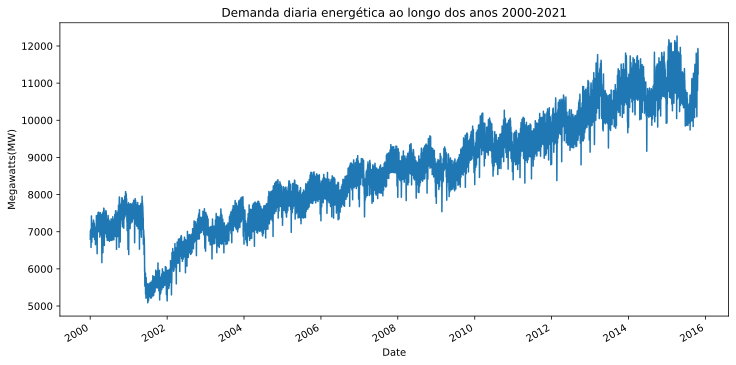

In [11]:
#draft
df["Megawatts(MW)"].plot(figsize=(12,6))
plt.title("Demanda diaria energética ao longo dos anos 2000-2021")
plt.ylabel("Megawatts(MW)")
plt.show()

Uma análise visual inicial é possível verificar tendência de crescimento e sazonalidade na série temporal a ser examinada.

####Histograma

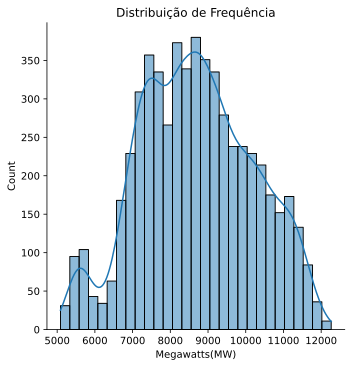

In [12]:
#frequency distribution and kde
sns.displot(data=df, kde=True, x="Megawatts(MW)")
plt.title("Distribuição de Frequência")
plt.show()

Se o dataset apresenta estacionaridade, o resumo estatístico se apresenta consistente ao longo do tempo. Com uma média e variância constante a distribuição de frequência deve apresentar uma curva Gaussiana. 

###Análise Anual

#####Gráfico de linha

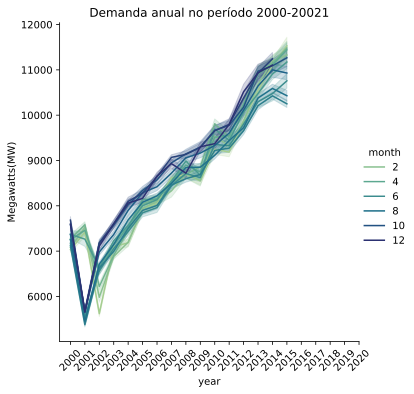

In [13]:
#line graph, month, year and megawatts
sns.relplot(data=df, x="year", y="Megawatts(MW)", hue="month", kind="line", palette="crest")
plt.title("Demanda anual no período 2000-20021")
plt.xticks(np.arange(2000,2021,1), rotation=45)
plt.show()

Ao longo dos anos a demanda energética mostra em crescimento

#####Boxplot

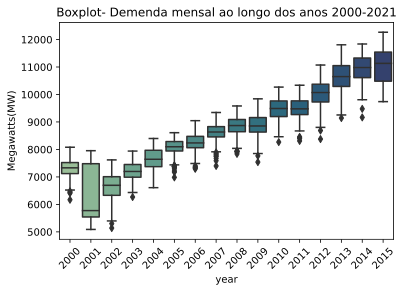

In [14]:
sns.boxplot(data=df, x="year", y="Megawatts(MW)", palette="crest")
plt.xticks(rotation=45)
plt.title("Boxplot- Demenda mensal ao longo dos anos 2000-2021")
plt.show()

Analisando o gráfico das médias móveis é possível verificar uma tendência de crescimento e um grau de sazonalidade.

###Análise Mensal

####Estrutura de dados

Estrutura de dados **Wide-form** para melhor análise dos meses

In [15]:
x = df.groupby(["year", "month"])["Megawatts(MW)"].mean()
df_wide = x.unstack()
df_wide.head()

month,1,2,3,4,5,6,7,8,9,10,11,12
year,,,,,,,,,,,,
2000,7032.700000,7079.517241,7267.735484,7250.000000,7367.354839,7172.266667,7121.645161,7253.477419,7371.763333,7589.177419,7682.820000,7593.941935
2001,7416.719355,7525.896429,7582.203226,7460.503333,7265.154839,5541.440000,5376.812903,5451.838710,5667.013333,5665.641935,5646.013333,5670.300000
2002,5620.593548,5982.232143,6219.254839,6550.773333,6633.738710,6568.826667,6625.387097,6713.351613,6980.776667,7172.693548,7184.543333,7112.304516
2003,7098.160645,6881.578929,6907.893226,7151.284333,7229.410645,7059.194000,6996.116774,7145.355161,7366.692667,7569.277419,7598.930000,7604.600000
2004,7184.319355,7198.251724,7458.206452,7529.793333,7567.158065,7434.856667,7504.683871,7689.051613,7899.770000,8021.996774,8097.356667,8060.867742


####Gráfico de linha

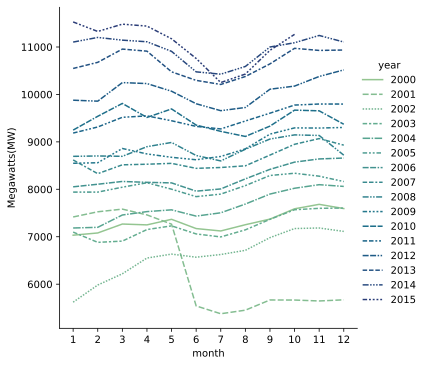

In [16]:
sns.relplot(data=df_wide.transpose(), kind="line", palette="crest")
plt.xticks(range(1, 13))
plt.ylabel("Megawatts(MW)")
plt.show()

####Gráfico de barras

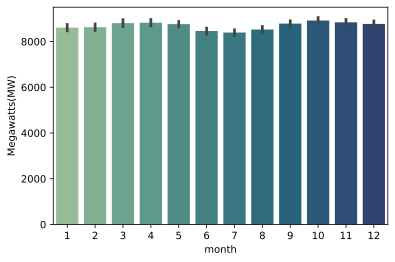

In [17]:
sns.barplot(data=df, x="month", y="Megawatts(MW)", palette="crest");

A gente consegue perceber pelo gráfico que ao longo dos meses 6 e 8 tem uma tendência de decrecimento e um grau de sazonalidade. 

####Boxplot

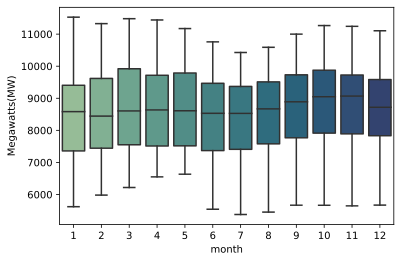

In [18]:
sns.boxplot(data=df_wide, palette="crest")
plt.ylabel("Megawatts(MW)")
plt.show()

###Análise semanal

####Gráfico de linha

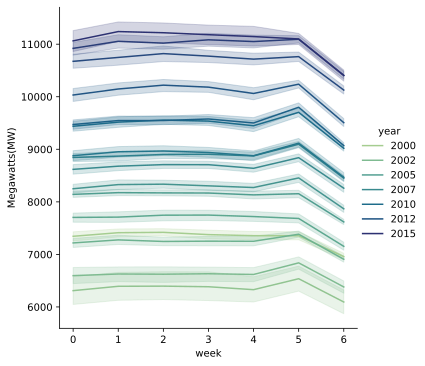

In [19]:
sns.relplot(data=df, x="week", y="Megawatts(MW)", hue="year", kind="line", palette="crest");

Segunda-feira = 0 e Domingo = 6

Podemos analisar que de sábado para domingo apresenta uma queda no consumo.

####Gráfico de Barras

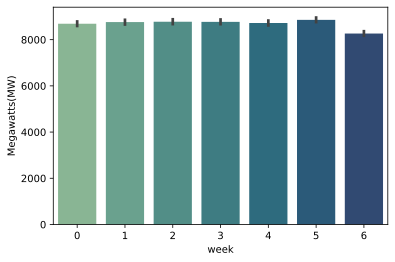

In [20]:
sns.barplot(data=df, x="week", y="Megawatts(MW)", palette="crest");

####Boxplot

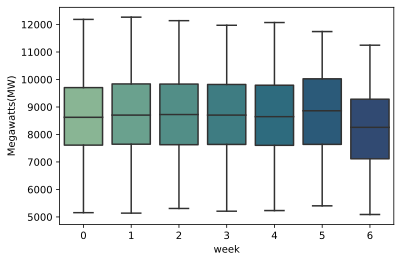

In [21]:
sns.boxplot(data=df, x="week", y="Megawatts(MW)", palette="crest");

#3. Tranformações

* Há basicamente, duas razões para se transformar os dados originais: estabilizar a variância e tornar o efeito sazonal aditivo
* Uma outra razão da transformação é obter uma distribuição  para os dados mais simétricos e próximo do normal

##3.1 Testes Estatísticos

###Dickey-Fuller Test(ADF)

O ADF testa a hipótese nula de que uma raiz unitária está presente na amostra da série temporal.

* Hipótese nula(H0): se aceita, sugere que a série tempora tem raiz unitária, o que significa que **não é estacionária**. 
* Hipótese alternativa(H1): A hipótese nula é rejeitada, sugere que a série tempooral não tem uma raiz unitária, o que siginfica que é **estacionária**.
    * valor p > 0.05: Aceita H0, os dados tem uma raiz unitária e **não é estacionária** 
    * valor p =< 0.05: Rejeita H0, os dados não tem raiz unitária **é estacionária**

In [22]:
def test_dickfuller(timeseries):
  #Reference:https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html
  result = adfuller(x=timeseries["Megawatts(MW)"],autolag='AIC')
  dfoutput = pd.Series(result[0:4], index=["ADF Statistic:", "p-value:","#Lags Used:","Number of Observations Used:"])
  for key, value in result[4].items():
    dfoutput['Critical Value (%s)'%key] = value
  print (dfoutput)
  if result[1] > 0.05:
    print("p-value great then 0.05 then Accept H0, the data has a unit root and is non-stationary")
  else:
    print("p-value less then 0.05 then indicate reject H0, maybe the date not have unit root and is stationary")


test_dickfuller(df)

ADF Statistic:                    -0.694104
p-value:                           0.848271
#Lags Used:                       34.000000
Number of Observations Used:    5739.000000
Critical Value (1%)               -3.431490
Critical Value (5%)               -2.862044
Critical Value (10%)              -2.567038
dtype: float64
p-value great then 0.05 then Accept H0, the data has a unit root and is non-stationary


In [23]:
#Select a percentage from the time series
data_proportion = lambda serie, percent=1.0: serie[-int(percent * len(serie)):]

###KPSS

In [24]:
def test_kpss(timeseries):
  print('\nResults of KPSS Test:')
  result = kpss(timeseries, regression='c')
  print('KPSS Statistic: %f' % result[0])
  print('p-value: %f' % result[1])
  for key, value in result[3].items():
      print('Critial Values:')
      print(f'   {key}, {value}')

###Teste de Estacionaridade

In [25]:
def check_stationarity(timeseries):
  plot_mean_std(timeseries)
  test_dickfuller(timeseries)
  test_kpss(timeseries)

##3.2 Logarítmo

In [26]:
#ts_log = np.log(ts_50_per)
#plt.plot(ts_log)
#check_stationarity(ts_log)
#moving_avg = pd.Series(ts_log).rolling(window=12).mean()
#plt.plot(ts_log)
#plt.plot(moving_avg, color='red')
#ts_log_moving_avg_diff = ts_log - moving_avg
#ts_log_moving_avg_diff.dropna(inplace=True)
#test_stationarity(ts_log_moving_avg_diff)

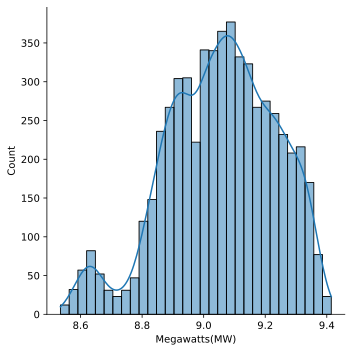

In [27]:
ts_log = np.log(df["Megawatts(MW)"])
sns.displot(data=ts_log, kde=True);

##3.3 Box-cox

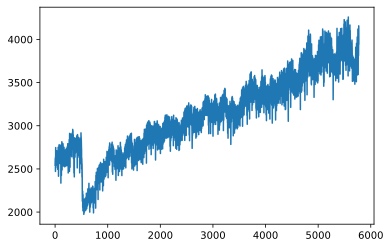

In [28]:
from scipy import stats
fitted_data, fitted_lambda = stats.boxcox(df["Megawatts(MW)"])
plt.plot(fitted_data)
plt.show()

##3.4 Médias moveis

In [29]:
def plot_mean_std(timeseries):
  #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()
    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.plot(figsize=(12,6))
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

#4. Decomposição

Verificação de itens nulos

In [30]:
nulls = df['Megawatts(MW)'].isnull().sum()
print (f'The numbers of nulls: {nulls}')

The numbers of nulls: 0


###Modelo Aditiva

Sinteticamente, é um modelo de dados em que os efeitos dos fatores individuais são diferenciados e adicionados para modelar os dados. Pode ser representado por:

```y (t) = Nível + Tendência + Sazonalidade + Ruído```

* Nível : é o valor médio da série.
* Tendência : é o valor crescente ou decrescente na série.
* Sazonalidade : é a repetição do ciclo de curto prazo na série.
* Ruído : é a variação aleatória da série.

No modelo aditivo, o comportamento é linear onde as mudanças ao longo do tempo miq'p097y4'são feitas de forma consistente pela mesma quantidade, como uma tendência linear. Nessa situação, a sazonalidade linear tem a mesma amplitude e frequência.

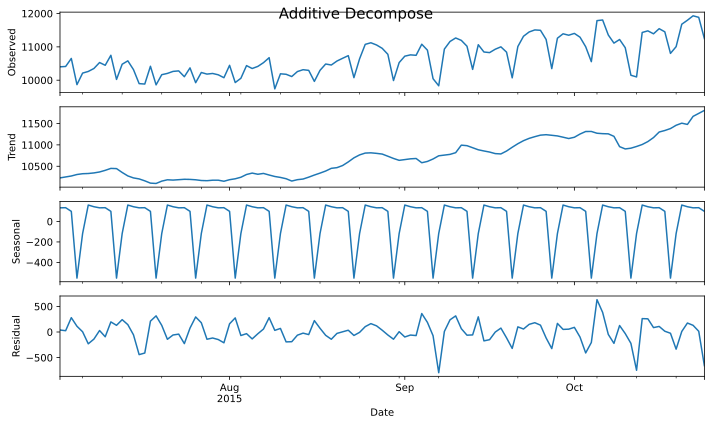

In [31]:
df_2_percent = data_proportion(df["Megawatts(MW)"],percent=0.02)
additive_decompose = seasonal_decompose(df_2_percent, model="additive", extrapolate_trend="freq")
plt.rcParams["figure.figsize"] = (10,6)
additive_decompose.plot().suptitle("Additive Decompose",size=15)
plt.show()

In [32]:
# Actual Values = Sum of (Seasonal + Trend + Resid)
df_reconstructed = pd.concat([additive_decompose.seasonal, additive_decompose.trend, additive_decompose.resid, additive_decompose.observed], axis=1)
df_reconstructed.columns = ['seas', 'trend', 'resid', 'actual_values']
df_reconstructed.head()

,seas,trend,resid,actual_values
Date,,,,
2015-07-02,133.438276,10228.491520,39.097204,10401.027
2015-07-03,134.619009,10250.710219,25.566772,10410.896
2015-07-04,98.985767,10272.928918,279.804315,10651.719
2015-07-05,-553.569725,10307.779143,112.189582,9866.399
2015-07-06,-118.242939,10326.110857,4.535082,10212.403


###Decomposiçao Multiplicativa

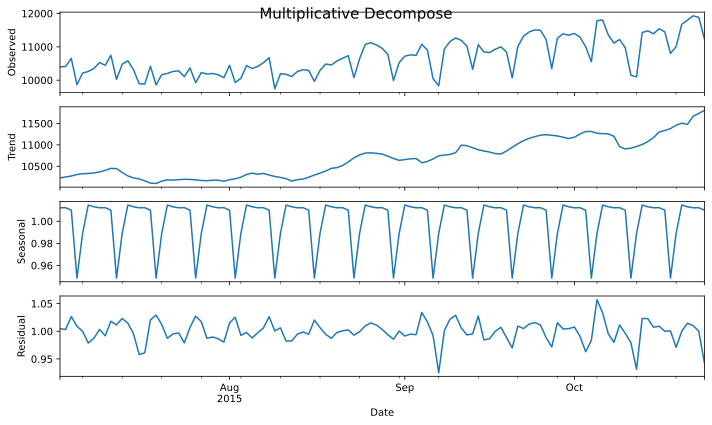

In [33]:
df_2_percent = data_proportion(df["Megawatts(MW)"],percent=0.02)
mult_decompose = seasonal_decompose(df_2_percent, model="multiplicative", extrapolate_trend="freq")
mult_decompose.plot().suptitle("Multiplicative Decompose",size=15)
plt.show()

In [34]:
# Actual Values = Product of (Seasonal * Trend * Resid)
df_reconstructed = pd.concat([mult_decompose.seasonal, mult_decompose.trend, mult_decompose.resid, mult_decompose.observed], axis=1)
df_reconstructed.columns = ['seas', 'trend', 'resid', 'actual_values']
df_reconstructed.head()

,seas,trend,resid,actual_values
Date,,,,
2015-07-02,1.012207,10228.491520,1.004605,10401.027
2015-07-03,1.012303,10250.710219,1.003284,10410.896
2015-07-04,1.010043,10272.928918,1.026563,10651.719
2015-07-05,0.948587,10307.779143,1.009059,9866.399
2015-07-06,0.989030,10326.110857,0.999957,10212.403


Sazonalidade  é a característica de uma série temporal com comportamento padrão dentro de um determinado intervalo de tempo.Se esse padrão se repetir no mesmo intervalo ao longo do tempo, teremos a presença de uma amostra com comportamento sazonal.

#5. Previsão dos Dados

TODO: horizonte de previsão

Previsões de séries temporais é um tópico com muitas aplicações possíveis, tais como previsão de preço de ativos, previsão do tempo, planejamento de negócios e muitos outros. 

Uma série temporal é usualmente modelada sob um processo estocástico, uma sequência de variáveis aleatória. Em uma previsão, estamos no momento ```Y(t)``` e temos interesse em estimar ```Y(t+1)```, usando somente as informações disponíveis até o momento ```t```.

* Análise Gráfica
* Características Estatísticas
* Teste Estatísticos

##Modelo Naive/Persistente

O modelo *Naive/Persistente* é o exemplo mais básico e "inocente" de preditor para uma série temporal. A ideia do modelo é que o valor previsto para o período atual ```t``` seja igual ao valor do período ```t-1```.

In [35]:
# split into train and test sets
X = df.values
train_size = int(len(X) * 0.75)
train, test = X[1:train_size], X[train_size:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]


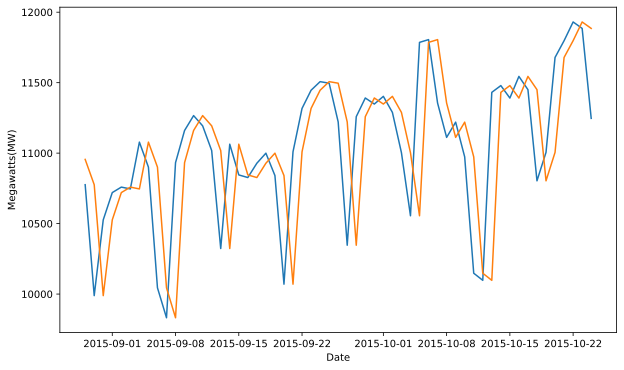

In [36]:
df["naive"] = df["Megawatts(MW)"].shift(1)
df_percent_01 = data_proportion(df, percent=0.01)
sns.lineplot(data=df_percent_01["Megawatts(MW)"])
sns.lineplot(data=df_percent_01["naive"])
plt.show()

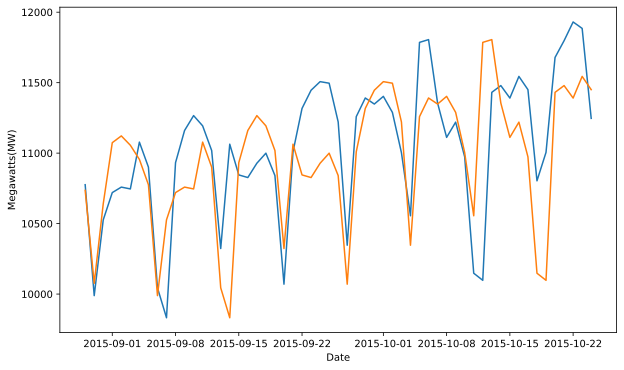

In [37]:
df["naive_seven"] = df["Megawatts(MW)"].shift(7)
df01 = data_proportion(df, percent=0.01)
sns.lineplot(data=df01["Megawatts(MW)"])
sns.lineplot(data=df01["naive_seven"])
plt.show()

##Validação

Iremos fazer a validação do modelo Naive calculando o erro médio quadrático, entre as previsões e os valores observados. 

In [38]:
erro_quad_mean =(((df['Megawatts(MW)'] - df['naive']) ** 2).mean()) //100
print(f"Erro médio quadrádrico do modelo naive:\n {erro_quad_mean}")

Erro médio quadrádrico do modelo naive:
 1285.0


In [39]:
erro_quad_mean_seven_days =((df['Megawatts(MW)'] - df['naive_seven']) ** 2).mean()
print(erro_quad_mean_seven_days//100)

902.0


O modelo Naive é utilizado como referência para modelos mais sofisticados. A ideia é que modelos de previsão possuam erro médio quadrático menor que o modelo naive. Caso contrário, temos um modelo extremamente ineficaz.

Tanto a média quanto a variância contém pouca variação entre as metades das amostras. 
Isso também indica que a série é estacionária

In [40]:
cl = df.copy()

cl.resample("M").mean()

cl.head()

,Megawatts(MW),year,month,week,naive,naive_seven
Date,,,,,,
2000-01-02,6797.0,2000,1,6,NaN,NaN
2000-01-03,7024.0,2000,1,0,6797.0,NaN
2000-01-04,6921.0,2000,1,1,7024.0,NaN
2000-01-05,7025.0,2000,1,2,6921.0,NaN
2000-01-06,6881.0,2000,1,3,7025.0,NaN


## ARIMA

###Identificação

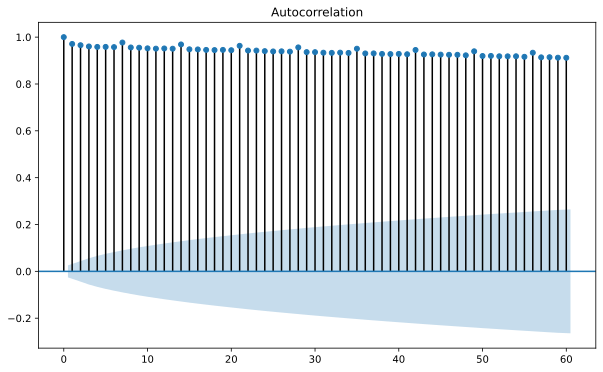

In [41]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(df["Megawatts(MW)"], lags=60)
plt.show()

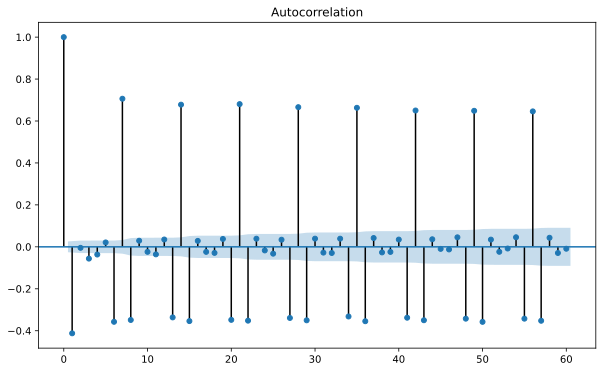

In [42]:
plot_acf(df["Megawatts(MW)"].diff().dropna(), lags=60)
plt.show()

Executando uma diferenciação podemos observar uma melhora na autocorrelação, com um comportamento mais estacionário.

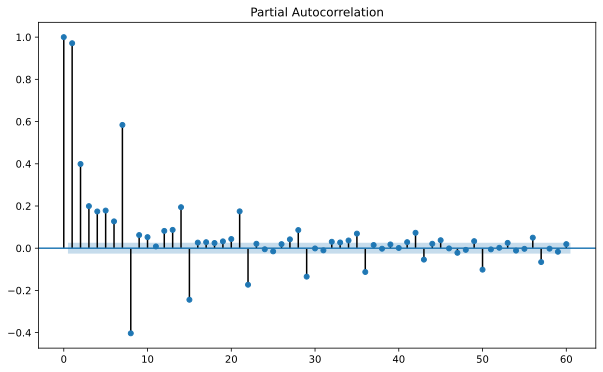

In [43]:
plot_pacf(df["Megawatts(MW)"], lags=60)
plt.show()

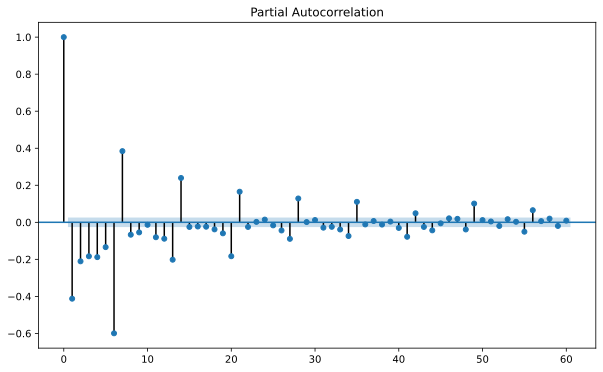

In [44]:
plot_pacf(df["Megawatts(MW)"].diff().dropna(), lags=60)
plt.show()

In [45]:
train = df.resample("D").last()

In [46]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(train["Megawatts(MW)"].fillna(0), freq="D", order=(2,1,2)).fit()
model.params

const                    0.771720
ar.L1.D.Megawatts(MW)   -0.736520
ar.L2.D.Megawatts(MW)    0.096641
ma.L1.D.Megawatts(MW)    0.037685
ma.L2.D.Megawatts(MW)   -0.793464
dtype: float64

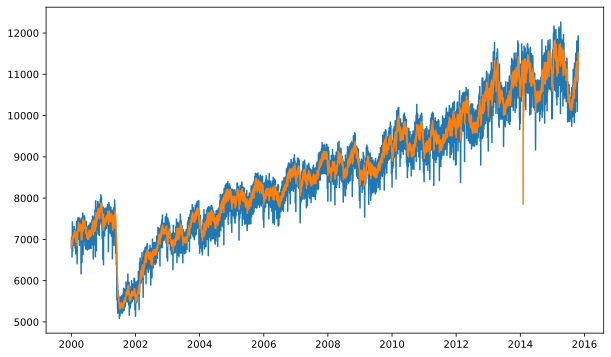

In [47]:
plt.plot(train["Megawatts(MW)"])
plt.plot(model.predict(typ='levels'))

In [48]:
model_test = ARIMA(df_test["Megawatts(MW)"].fillna(0), freq='D', order=(2,1,2)).fit(model.params)
print("Erro médio quadrático")
(model_test.resid ** 2).mean()

Erro médio quadrático


192990.12782656375

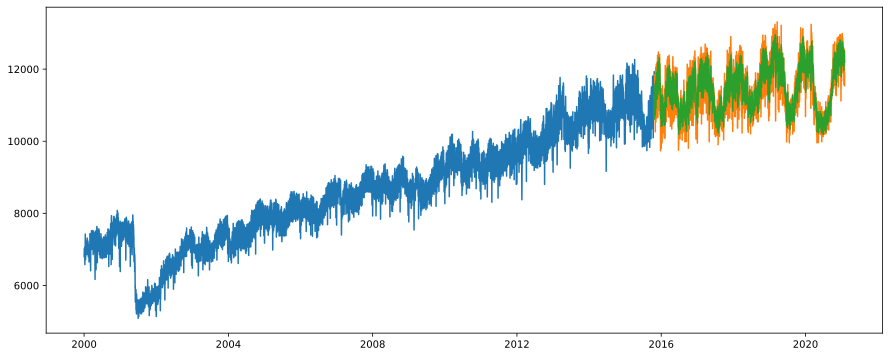

In [49]:
plt.figure(figsize=(15,6))
plt.plot(df["Megawatts(MW)"])
plt.plot(df_test["Megawatts(MW)"])
plt.plot(model_test.predict(typ='levels'))

In [50]:
configs = [(1, 1, 0), (1, 1, 1), (1, 1, 2), (1, 1, 3), (2, 1, 0), (2, 1, 1), (2, 1, 2), (2, 1, 3), (3, 1, 0), (3, 1, 1), (3,1, 2), (3, 1, 3)]
best = 192416
for config in configs:
  arima = ARIMA(train["Megawatts(MW)"].fillna(0), freq="D", order=config).fit()
  arima_test = ARIMA(df_test["Megawatts(MW)"].fillna(0), freq='D', order=config).fit(arima.params)
  erro = (arima_test.resid ** 2).mean()
  print(f"Config:{config} - EMQ {erro}")
  if erro < best:
    print(f"Melhor resultado:{config}, {erro}")


Config:(1, 1, 0) - EMQ 246641.42913849515
Config:(1, 1, 1) - EMQ 200939.23080552195
Config:(1, 1, 2) - EMQ 202631.53219329665
Config:(1, 1, 3) - EMQ 197669.8332088502
Config:(2, 1, 0) - EMQ 234832.38496023935
Config:(2, 1, 1) - EMQ 197195.5756628725
Config:(2, 1, 2) - EMQ 192990.12782656375
Config:(2, 1, 3) - EMQ 198517.4635051864
Config:(3, 1, 0) - EMQ 226693.55618668027
Config:(3, 1, 1) - EMQ 195236.89264869856
Config:(3, 1, 2) - EMQ 192416.19837559471
Config:(3, 1, 3) - EMQ 179697.26554120722
Melhor resultado:(3, 1, 3), 179697.26554120722


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
